In [2]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

In [5]:
#define model
class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass,self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
#initialize model
model=TheModelClass()
#initialize optimizer
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
#print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor,'\t',model.state_dict()[param_tensor].size())
    
#print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name,'\t',optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [3008291748744, 3008291748888, 3008291748960, 3008291749032, 3008291749104, 3008291749176, 3008291749248, 3008291746872, 3008291749320, 3008291749392]}]


In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets,models,transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch version:",torch.__version__)
print("Torchvision version:",torchvision.__version__)

PyTorch version: 0.4.1
Torchvision version: 0.2.1


In [2]:
#inputs

data_dir="./hymenoptera_data"
#Models to choose from[ResNet,AlexNet,vgg,squeezenet,densenet,inception]
model_name="squeezenet"
#number of classes in the dataset
num_classes=2
#batch size for training(change depending on how mang memories you have)
batch_size=8
#number of epochs to train for
num_epochs=15
#flags for finetune or feature extract
feature_extract=True

In [3]:
#Model training and validation code
#每个epoch后进行一次validation，根据validation准确率追踪最佳模型，每个epoch输出training和validation accuracy
def train_model(model,dataloaders,criterion,optimizer,num_epochs=25,is_inception=False):
    since=time.time()
    val_acc_history=[]
    best_model_wts=copy.deepcopy(model.state_dict())
    best_acc=0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        #each epoch has training and validation phase
        for phase in ['train','val']:
            if phase=='train':
                model.train() #set model to training mode
            else:
                model.eval() #set model to validation mode
            running_loss=0.0
            running_corrects=0
            #Iterator over data
            for inputs,labels in dataloaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                #zero the parameter gradient
                optimizer.zero_grad()
                #forward,如果是训练模式，记录模型
                with torch.set_grad_enabled(phase=='train'):
                    #训练时考虑inception网络的附属输出，计算损失函数
                    if is_inception and phase=='train':
                        outputs,aux_outputs=model(inputs)
                        loss1=criterion(outputs,labels)
                        loss2=criterion(aux_outputs,labels)
                        loss=loss1+0.4*loss2
                    else:
                        outputs=model(inputs)
                        loss=criterion(outputs,labels)
                    #预测的类别
                    _,preds=torch.max(outputs,1)
                    #训练：反向传播和更新参数
                    if phase=='train':
                        loss.backward()
                        optimizer.step()      
                #statistics
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==labels.data)
            epoch_loss=running_loss/len(dataloaders[phase].dataset)
            epoch_acc=running_corrects.double()/len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            #deep copy the model
            if phase=='val' and epoch_acc>best_acc:
                best_model_wts=copy.deepcopy(model.state_dict())
                best_acc=epoch_acc
            if phase=='val':
                val_acc_history.append(epoch_acc)
        print()
    time_elapsed=time.time()-since
    print('Train completed in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best validation accuracy: {:.4f}'.format(best_acc))
    #load best model weights
    model.load_state_dict(best_model_wts)
    return model,val_acc_history

In [4]:
#set model parametes'requires_grad attribute
#默认加载的预训练模型requires_grad属性为True
def set_parameters_requires_grad(model,feature_extraction):
    if feature_extraction:
        for param in model.parameters():
            param.requires_grad=False

In [5]:
#CNN模型的最后一层通常是FC层，neural节点数目是数据集中的类别数目
#initialize and reshape the network，修改网络最后一层
def initialize_model(model_name,num_classes,feature_extract,use_pretrained=True):
    model_ft=None
    input_size=0   #输入图片的尺寸
    
    if model_name=='resnet':
        model_ft=models.resnet18(pretrained=use_pretrained)
        set_parameters_requires_grad(model_ft,feature_extract)
        num_ftrs=model_ft.fc.in_features
        #重新定义最后一层全连接层
        model_ft.fc=nn.Linear(num_ftrs,num_classes)
        input_size=224
    elif model_name=='alexnet':
        model_ft=models.alexnet(pretrained=use_pretrained)
        set_parameters_requires_grad(model_ft,feature_extract)
        num_ftrs=model_ft.classifier[6].in_features
        model_ft.classifier[6]=nn.Linear(num_ftrs,num_classes)
        input_size=224
    elif model_name=='vgg':
        model_ft=models.vgg11_bn(pretrained=use_pretrained)
        set_parameters_features_grad(model_ft,feature_extract)
        num_ftrs=model_ft.classifier[6].in_features
        model_ft.classifier[6]=nn.Linear(num_ftrs,num_classes)
        input_size=224
    elif model_name=='squeezenet':
        model_ft=models.squeezenet1_0(pretrained=use_pretrained)
        set_parameters_requires_grad(model_ft,feature_extract)
        model_ft.classifier[1]=nn.Conv2d(512,num_classes,kernel_size=(1,1),stride=(1,1))
        model_ft.num_classes=num_classes
        input_size=224
    elif model_name=='densenet':
        model_ft=models.densenet121(pretrained=use_pretrained)
        set_parameters_requires_grad(model_ft,feature_extract)
        num_ftrs=model_ft.classifier.in_features
        model_ft.classifier=nn.Linear(num_ftrs,num_classes)
        input_size=224
    elif model_name=='inception':
        model_ft=models.inception_v3(pretrained=use_pretrained)
        set_parameters_requires_grad(model_ft,feature_extract)
        #handle the auxilary net
        num_ftrs=model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc=nn.Linear(num_ftrs,num_classes)
        #hadle the primary net
        num_ftrs=model_ft.fc.in_features
        model_ft.fc=nn.Linear(num_ftrs,num_classes)
        input_size=299
    else:
        print('Invalid model name.Exit...')
        exit()
    return model_ft,input_size
#initialize model for this run
model_ft,input_size=initialize_model(model_name,num_classes,feature_extract,use_pretrained=True)
print(model_ft)

C:\Users\13051\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\Users\13051\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

In [6]:
#Data augmentation and normalization for training
data_transforms={
    'train':transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}
print('Initializing datasets and dataloaders....')
#create training and validation dataset
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}
#create training and validation dataloader
dataloaders_dict={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=batch_size,shuffle=True,num_workers=4)
                      for x in ['train','val']}
#detect if we have a GPU available
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

Initializing datasets and dataloaders....
cuda:0


In [7]:
#send the model to GPU
model_ft=model_ft.to(device)
#将需要优化更新的参数聚集到一起，finetuning所有参数都要更新，feature extract只更新最后一层参数
params_to_update=model_ft.parameters()
print('Params to learn:')
if feature_extract:
    params_to_update=[]
    for name,params in model_ft.named_parameters():
        if params.requires_grad==True:
            params_to_update.append(params)
            print('\t',name)
else:
    for name,params in model_ft.named_parameters():
        if params.requires_grad==True:
            print('\t',name)
#定义优化函数
optimizer=optim.SGD(params_to_update,lr=0.001,momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [8]:
#Run training and validation step
#Setup the loss function
criterion=nn.CrossEntropyLoss()
#training and evaluation
model_ft,hist=train_model(model_ft,dataloaders_dict,criterion,optimizer,num_epochs=num_epochs,is_inception=(model_name=='inception'))

Epoch 0/14
----------
train Loss: 0.5952 Acc: 0.7254
val Loss: 0.3562 Acc: 0.8758

Epoch 1/14
----------
train Loss: 0.2845 Acc: 0.8607
val Loss: 0.3288 Acc: 0.9216

Epoch 2/14
----------
train Loss: 0.2134 Acc: 0.9221
val Loss: 0.3294 Acc: 0.9216

Epoch 3/14
----------
train Loss: 0.2487 Acc: 0.8811
val Loss: 0.2875 Acc: 0.9216

Epoch 4/14
----------
train Loss: 0.1905 Acc: 0.9098
val Loss: 0.3128 Acc: 0.9216

Epoch 5/14
----------
train Loss: 0.1401 Acc: 0.9508
val Loss: 0.3168 Acc: 0.9150

Epoch 6/14
----------
train Loss: 0.1805 Acc: 0.9139
val Loss: 0.3118 Acc: 0.9150

Epoch 7/14
----------
train Loss: 0.1691 Acc: 0.9221
val Loss: 0.3085 Acc: 0.9346

Epoch 8/14
----------
train Loss: 0.1632 Acc: 0.9221
val Loss: 0.3287 Acc: 0.9281

Epoch 9/14
----------
train Loss: 0.1554 Acc: 0.9344
val Loss: 0.3226 Acc: 0.9216

Epoch 10/14
----------
train Loss: 0.1144 Acc: 0.9508
val Loss: 0.3364 Acc: 0.9216

Epoch 11/14
----------
train Loss: 0.1280 Acc: 0.9549
val Loss: 0.3871 Acc: 0.8889

Ep

C:\Users\13051\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\Users\13051\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


Epoch 0/14
----------
train Loss: 0.6907 Acc: 0.5205
val Loss: 0.6931 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.6934 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 2/14
----------
train Loss: 0.6931 Acc: 0.5000
val Loss: 0.6931 Acc: 0.4575

Epoch 3/14
----------
train Loss: 0.6932 Acc: 0.5082
val Loss: 0.6931 Acc: 0.4575

Epoch 4/14
----------
train Loss: 0.6932 Acc: 0.5000
val Loss: 0.6931 Acc: 0.4575

Epoch 5/14
----------
train Loss: 0.6930 Acc: 0.5082
val Loss: 0.6931 Acc: 0.4575

Epoch 6/14
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 7/14
----------
train Loss: 0.6930 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 8/14
----------
train Loss: 0.6932 Acc: 0.5000
val Loss: 0.6931 Acc: 0.4575

Epoch 9/14
----------
train Loss: 0.6925 Acc: 0.5123
val Loss: 0.6931 Acc: 0.4575

Epoch 10/14
----------
train Loss: 0.6900 Acc: 0.5082
val Loss: 0.6995 Acc: 0.4575

Epoch 11/14
----------
train Loss: 0.6898 Acc: 0.4918
val Loss: 0.6931 Acc: 0.4575

Ep

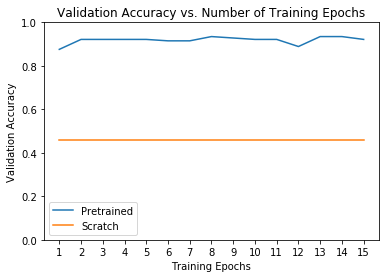

In [9]:
#Comparison with model trained from scratch
scratch_model,_=initialize_model(model_name,num_classes,feature_extract=False,use_pretrained=False)
scratch_model=scratch_model.to(device)
scratch_criterion=nn.CrossEntropyLoss()
scratch_optimizer=optim.SGD(scratch_model.parameters(),lr=0.001,momentum=0.9)
_,scratch_hist=train_model(scratch_model,dataloaders_dict,scratch_criterion,scratch_optimizer,
                           num_epochs=num_epochs,is_inception=(model_name=='inception'))
#绘制validation accuracy随epoch的曲线
ohist=[]
shist=[]
ohist=[h.cpu().numpy() for h in hist]
shist=[h.cpu().numpy() for h in scratch_hist]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1,num_epochs+1,1))
plt.legend()
plt.show()